In [1]:
from pprint import pprint
import data_reader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
path2submits  = 'iui20_ideaSubmits.csv'
path2requests = 'iui20_inspirationRequests.csv'
seconds_per_bucket = 15
train_percentage = 0.7

In [3]:
#load data as sessions
sessions = data_reader.load_data_as_sessions_dict(path2submits, path2requests, seconds_per_bucket)
# calculate avoiders and seekers
sessions = data_reader.add_avoiders_undetermined_and_seekers(sessions)
# create train and test set of worker ids
train_worker_ids, test_worker_ids = data_reader.split_worker_ids_into_train_test(sessions, train_percentage=train_percentage)

/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.21159420289855072,
 0.21159420289855072,
 0.21052631578947367,
 0.38095238095238093,
 0.38095238095238093,
 0.30885780885780884,
 0.3416666666666666,
 0.31516936671575846,
 0.3484042553191489,
 0.4083171730230554,
 0.34476190476190477,
 0.41913580246913584,
 0.43709582598471486,
 0.3772357723577236,
 0.47295708406819514,
 0.45565202587674497,
 0.723445692883895,
 0.744107744107744,
 0.4250550589454593,
 0.5755844155844155,
 0.5533333333333333,
 0.5763157894736842,
 0.6103896103896104,
 0.5229397422500871,
 0.6109438470728793,
 0.5327380952380952,
 0.5488095238095237,
 0.5549971313826735,
 0.5921544715447155,
 0.5856798623063684,
 0.629059829059829,
 0.6078431372549019,
 0.5797134238310709,
 0.6042536275094416,
 0.6886973180076629,
 0.8361332154435602,
 0.68868778280543,
 0.5125291375291375,
 0.5125291375291375]
[array([[ 0,  0, 21],
       [ 0,  0, 21],
       [ 0,  0, 73]]),
 array([[ 0,  0, 21],
       [ 0,  0, 21],
       [ 0,  0, 73]]),
 array([[ 0,  0, 21],
       [ 0,  0, 21],

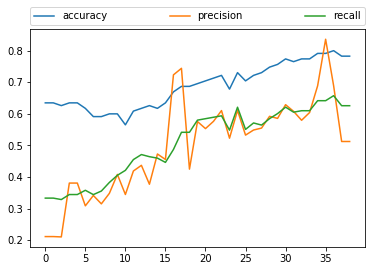

In [4]:
# iterate through different numbers of buckets
# train a classifier for each different numbers of buckets
# test on test examples
# get roc curve
conf_matrices    = []
accuracies       = []
precisions_micro = []
recalls_micro    = []
max_number_of_buckets = 40
for nr_of_buckets in range(1, max_number_of_buckets):
    x_tr, y_tr, x_te, y_te = data_reader.create_train_test_dataset(nr_of_buckets, train_worker_ids, test_worker_ids, sessions, train_percentage)
    #clf = DecisionTreeClassifier()
    clf = RandomForestClassifier(200)
    clf.fit(x_tr, y_tr)
    y_pre = clf.predict(x_te)
    conf_matrices   .append(confusion_matrix(y_te, y_pre))
    accuracies      .append(accuracy_score  (y_te, y_pre))
    precisions_micro.append(precision_score (y_te, y_pre, average='macro'))
    recalls_micro   .append(recall_score    (y_te, y_pre, average='macro'))

# [[tn, fp, fn, tp], ...]
#conf_matrices = np.array([conf_m.ravel() for conf_m in conf_matrices])

pprint(precisions_micro)


pprint(conf_matrices)
plt.plot(accuracies,       label='accuracy')
plt.plot(precisions_micro, label='precision')
plt.plot(recalls_micro,    label='recall')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.show()

/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


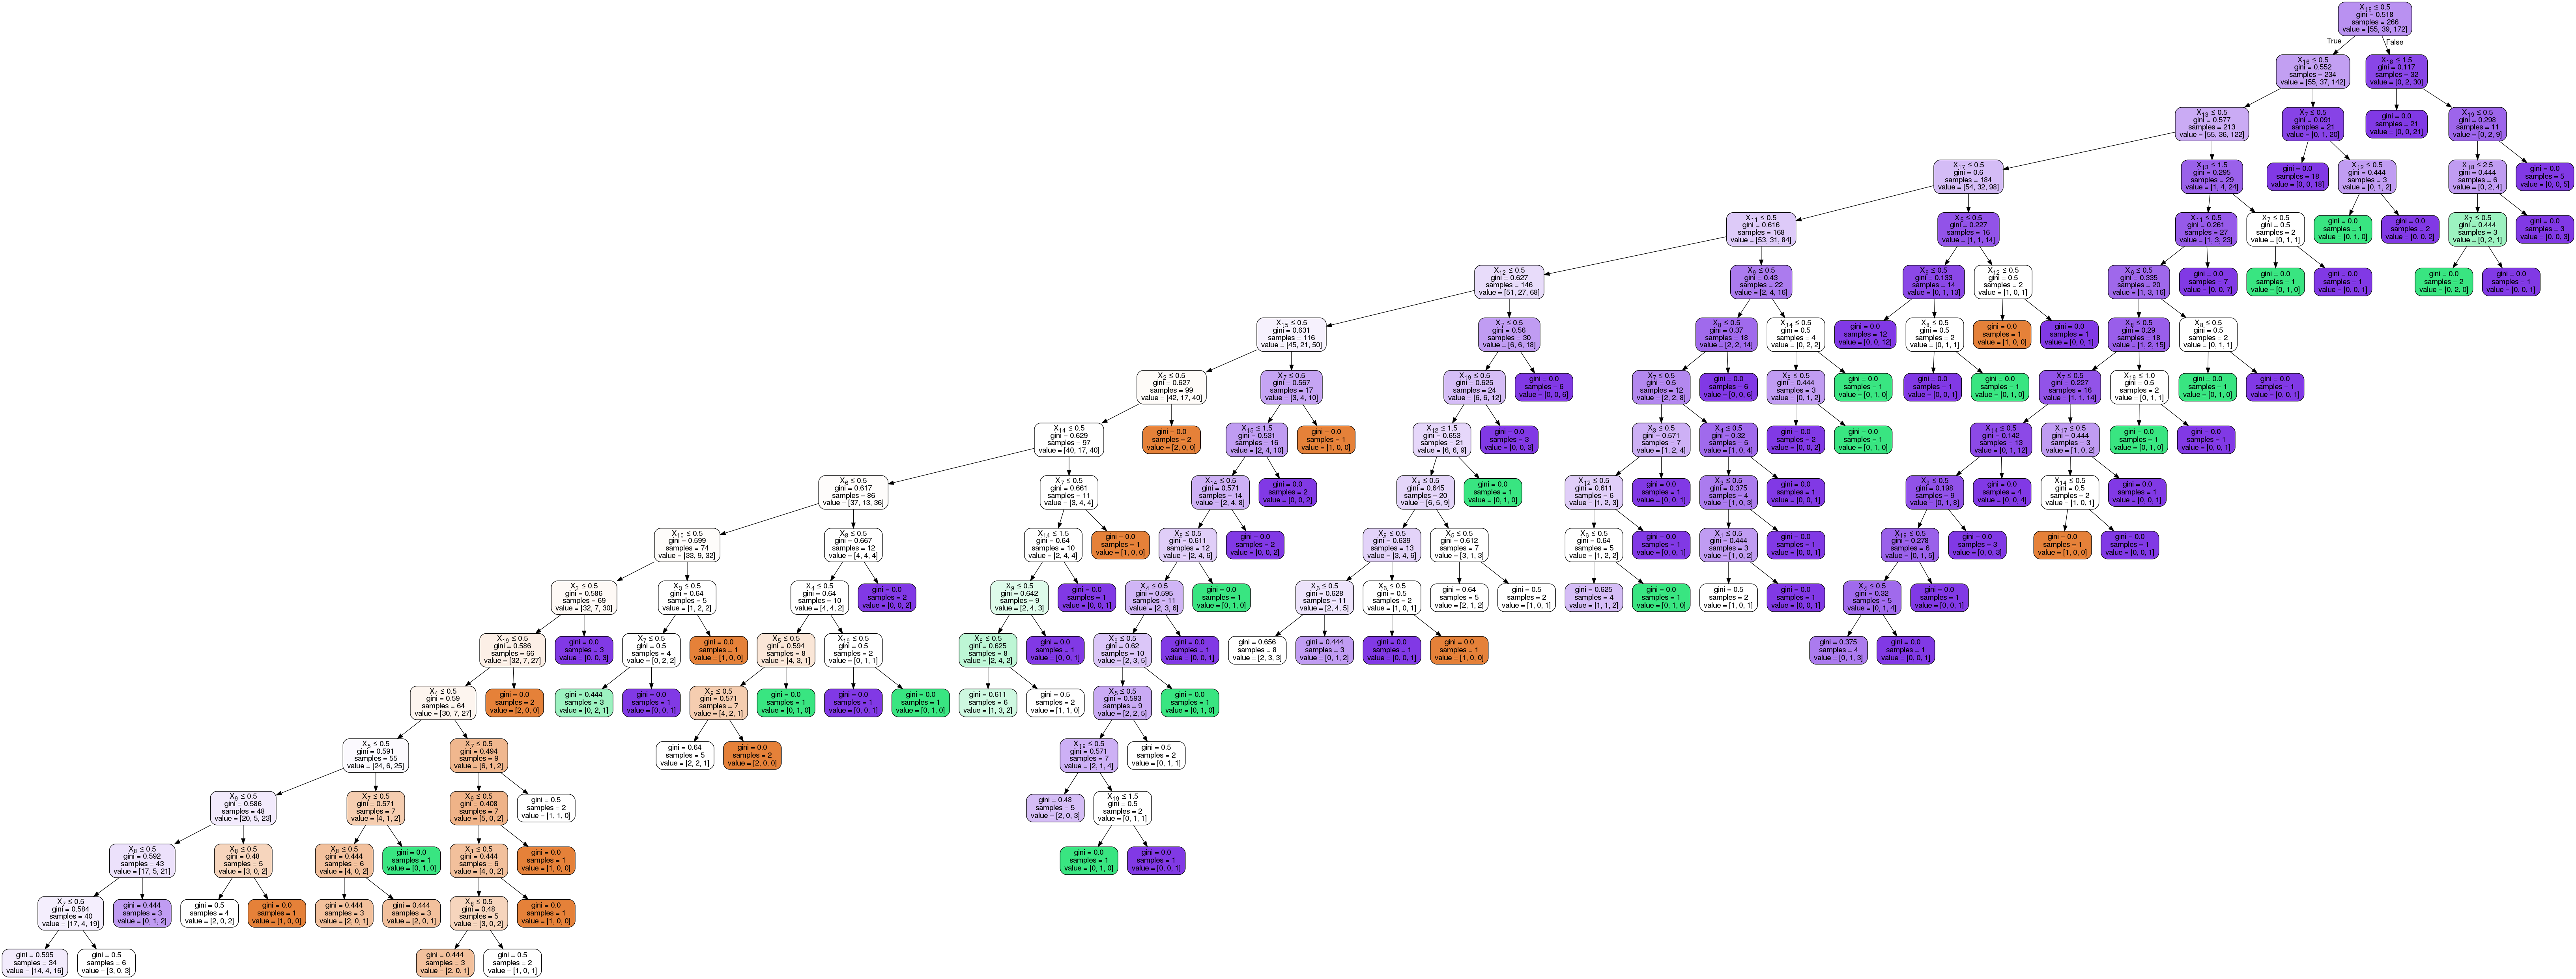

In [5]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

train_percentage = 1.0
nr_of_buckets = 10
x_tr, y_tr, x_te, y_te = data_reader.create_train_test_dataset(nr_of_buckets, train_worker_ids, test_worker_ids, sessions, train_percentage)
clf = DecisionTreeClassifier()
clf.fit(x_tr, y_tr)
    
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())